# CDC Yearly Health Data Analysis

**Source**: CDC Data Repository --> https://chronicdata.cdc.gov/browse?q=PLACES%202022  
**Link to Specific Dataset**: ("PLACES: Local Data for Better Health, County Data 2022 release")  
**API & Variable Documentation**: https://dev.socrata.com/foundry/chronicdata.cdc.gov/duw2-7jbt 
**Data Dictionary for Info About 'Measure' columns options**: https://chronicdata.cdc.gov/500-Cities-Places/PLACES-and-500-Cities-Data-Dictionary/m35w-spkz  
**Interesting Github Project for using API to extract (May not need)**: https://github.com/alipphardt/cdc-wonder-api/blob/master/CDC%2BWONDER%2BAPI%2BExample.ipynb  

In [10]:
#LocationID is the County FIPS

# Loading Libraries

In [11]:
import pandas as pd
import censusdata
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [12]:
sharedFolder = '/work/group/egodat/reu23_clark/'
dataFolder = sharedFolder + 'data/'

In [13]:
cdc_data = pd.read_csv("PLACES__Local_Data_for_Better_Health__County_Data_2022_release.csv")

In [14]:
#cdc_data = gdp_data.rename(columns={"TimePeriod": "year", "DataValue": "gdp"})


In [15]:
cdc_data

,Year,StateAbbr,StateDesc,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,...,Data_Value_Footnote,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,LocationID,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text,Geolocation
0,2020,US,United States,NaN,BRFSS,Prevention,Current lack of health insurance among adults ...,%,Crude prevalence,15.3,...,NaN,15.0,15.7,331449281,59,PREVENT,ACCESS2,CrdPrv,Health Insurance,NaN
1,2020,AL,Alabama,Talladega,BRFSS,Health Outcomes,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,15.1,...,NaN,14.3,15.9,79985,1121,HLTHOUT,DIABETES,CrdPrv,Diabetes,POINT (-86.1759302 33.3693135)
2,2020,AL,Alabama,Tallapoosa,BRFSS,Health Outcomes,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,16.0,...,NaN,15.0,17.0,40133,1123,HLTHOUT,DIABETES,CrdPrv,Diabetes,POINT (-85.7996176 32.8633076)
3,2020,AL,Alabama,Wilcox,BRFSS,Prevention,Visits to doctor for routine checkup within th...,%,Age-adjusted prevalence,79.4,...,NaN,78.4,80.4,10206,1131,PREVENT,CHECKUP,AgeAdjPrv,Annual Checkup,POINT (-87.3049349 31.9900824)
4,2020,AK,Alaska,Aleutians East,BRFSS,Prevention,Cervical cancer screening among adult women ag...,%,Crude prevalence,68.3,...,NaN,65.2,71.4,3401,2013,PREVENT,CERVICAL,CrdPrv,Cervical Cancer Screening,POINT (-161.9974772 55.2450437)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188451,2019,WA,Washington,Skagit,BRFSS,Health Outcomes,High cholesterol among adults aged >=18 years ...,%,Crude prevalence,34.6,...,NaN,33.7,35.5,130789,53057,HLTHOUT,HIGHCHOL,CrdPrv,High Cholesterol,POINT (-121.8157703 48.4932917)
188452,2020,WI,Wisconsin,Oneida,BRFSS,Health Status,Mental health not good for >=14 days among adu...,%,Age-adjusted prevalence,13.9,...,NaN,12.8,15.0,35751,55085,HLTHSTAT,MHLTH,AgeAdjPrv,Mental Health,POINT (-89.5345333 45.7161762)
188453,2020,WI,Wisconsin,Oconto,BRFSS,Health Risk Behaviors,Current smoking among adults aged >=18 years,%,Crude prevalence,18.1,...,NaN,15.2,20.9,38383,55083,RISKBEH,CSMOKING,CrdPrv,Current Smoking,POINT (-88.2065162 44.9965754)
188454,2020,WV,West Virginia,Kanawha,BRFSS,Health Status,Fair or poor self-rated health status among ad...,%,Age-adjusted prevalence,18.8,...,NaN,16.3,21.3,176253,54039,HLTHSTAT,GHLTH,AgeAdjPrv,General Health,POINT (-81.5235156 38.3280675)


# Loading in Crosswalk and gdf for merging location data

In [16]:
xwalk = pd.read_pickle(dataFolder + "/xwalk_data_combined.pkl")
xwalk

,ctyname,bgrp,cbsa
0,"Rockingham County, NH",330150710012,14460
1,"Merrimack County, NH",330130380002,18180
2,"Merrimack County, NH",330130415001,18180
3,"Hillsborough County, NH",330110225011,31700
4,"Hillsborough County, NH",330110103022,31700
...,...,...,...
57404,"Elko County, NV",320079515003,21220
57405,"Elko County, NV",320079515003,21220
57406,"Elko County, NV",320079517002,21220
57407,"Elko County, NV",320079502001,21220


In [17]:
#Extract block group code
xwalk['fips'] = (xwalk['bgrp'] / 10**7).astype(int)
fipsToCbsa = xwalk.groupby('fips').first()['cbsa']
fipsToCbsa = dict(zip(fipsToCbsa.index, fipsToCbsa.values)) #Dict is faster for lookup

In [18]:
cdc_data['CBSA'] = cdc_data['LocationID'].apply(lambda c: fipsToCbsa.get(c, 99999))
cdc_data

,Year,StateAbbr,StateDesc,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,...,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,LocationID,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text,Geolocation,CBSA
0,2020,US,United States,NaN,BRFSS,Prevention,Current lack of health insurance among adults ...,%,Crude prevalence,15.3,...,15.0,15.7,331449281,59,PREVENT,ACCESS2,CrdPrv,Health Insurance,NaN,99999
1,2020,AL,Alabama,Talladega,BRFSS,Health Outcomes,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,15.1,...,14.3,15.9,79985,1121,HLTHOUT,DIABETES,CrdPrv,Diabetes,POINT (-86.1759302 33.3693135),45180
2,2020,AL,Alabama,Tallapoosa,BRFSS,Health Outcomes,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,16.0,...,15.0,17.0,40133,1123,HLTHOUT,DIABETES,CrdPrv,Diabetes,POINT (-85.7996176 32.8633076),10760
3,2020,AL,Alabama,Wilcox,BRFSS,Prevention,Visits to doctor for routine checkup within th...,%,Age-adjusted prevalence,79.4,...,78.4,80.4,10206,1131,PREVENT,CHECKUP,AgeAdjPrv,Annual Checkup,POINT (-87.3049349 31.9900824),99999
4,2020,AK,Alaska,Aleutians East,BRFSS,Prevention,Cervical cancer screening among adult women ag...,%,Crude prevalence,68.3,...,65.2,71.4,3401,2013,PREVENT,CERVICAL,CrdPrv,Cervical Cancer Screening,POINT (-161.9974772 55.2450437),99999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188451,2019,WA,Washington,Skagit,BRFSS,Health Outcomes,High cholesterol among adults aged >=18 years ...,%,Crude prevalence,34.6,...,33.7,35.5,130789,53057,HLTHOUT,HIGHCHOL,CrdPrv,High Cholesterol,POINT (-121.8157703 48.4932917),34580
188452,2020,WI,Wisconsin,Oneida,BRFSS,Health Status,Mental health not good for >=14 days among adu...,%,Age-adjusted prevalence,13.9,...,12.8,15.0,35751,55085,HLTHSTAT,MHLTH,AgeAdjPrv,Mental Health,POINT (-89.5345333 45.7161762),99999
188453,2020,WI,Wisconsin,Oconto,BRFSS,Health Risk Behaviors,Current smoking among adults aged >=18 years,%,Crude prevalence,18.1,...,15.2,20.9,38383,55083,RISKBEH,CSMOKING,CrdPrv,Current Smoking,POINT (-88.2065162 44.9965754),24580
188454,2020,WV,West Virginia,Kanawha,BRFSS,Health Status,Fair or poor self-rated health status among ad...,%,Age-adjusted prevalence,18.8,...,16.3,21.3,176253,54039,HLTHSTAT,GHLTH,AgeAdjPrv,General Health,POINT (-81.5235156 38.3280675),16620


#### **Remember to fix the averaging percentage issue with Data Values**

In [30]:
# variable_code: (readable_name, earliest_year, aggrigation_type)
aggType = {
    'StateDesc': 'first',
    'LocationName': 'first',
    'TotalPopulation': 'sum',
    'DataSource': 'first',
    'Data_Value_Unit': 'first',
    'Data_Value_Type': 'first',
    'Data_Value': 'mean',
    'MeasureId': 'first'
}

In [31]:
dataByCbsa = cdc_data.groupby(by=['CBSA', 'Measure','Year']).agg(aggType).reset_index()

In [32]:
dataByCbsa

,CBSA,Measure,Year,StateDesc,LocationName,TotalPopulation,DataSource,Data_Value_Unit,Data_Value_Type,Data_Value,MeasureId
0,10100,All teeth lost among adults aged >=65 years,2020,South Dakota,Brown,85110,BRFSS,%,Crude prevalence,10.125000,TEETHLOST
1,10100,Arthritis among adults aged >=18 years,2020,South Dakota,Brown,85110,BRFSS,%,Age-adjusted prevalence,23.275000,ARTHRITIS
2,10100,Binge drinking among adults aged >=18 years,2020,South Dakota,Brown,85110,BRFSS,%,Age-adjusted prevalence,20.550000,BINGE
3,10100,Cancer (excluding skin cancer) among adults ag...,2020,South Dakota,Brown,85110,BRFSS,%,Crude prevalence,7.025000,CANCER
4,10100,Cervical cancer screening among adult women ag...,2020,South Dakota,Brown,85110,BRFSS,%,Crude prevalence,84.275000,CERVICAL
...,...,...,...,...,...,...,...,...,...,...,...
27819,99999,Sleeping less than 7 hours among adults aged >...,2020,Colorado,Gunnison,700519204,BRFSS,%,Crude prevalence,33.689302,SLEEP
27820,99999,Stroke among adults aged >=18 years,2020,Alaska,Haines,700519204,BRFSS,%,Age-adjusted prevalence,3.767140,STROKE
27821,99999,Taking medicine for high blood pressure contro...,2019,Arkansas,Clay,700500512,BRFSS,%,Age-adjusted prevalence,68.189209,BPMED
27822,99999,Visits to dentist or dental clinic among adult...,2020,Alaska,Petersburg,700519204,BRFSS,%,Crude prevalence,57.479793,DENTAL


# Reading in GDF for Merging

In [27]:
gdf = pd.read_pickle(sharedFolder + 'gdf.pkl')
gdf

,CBSA,LSAD,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,NAME,geometry,metro,micro,buff,inBuff,commuteBuffCount_19,workingPop_19,commutePercent_19,commuteBuffCount_20,workingPop_20,commutePercent_20,liminal
0,10180,Metropolitan Statistical Area,176866,177829,179308,"Abilene, TX","POLYGON ((-11148262.500 3832132.455, -11148249...",False,False,"POLYGON ((-11309677.340 3783320.344, -11309649...",True,7720.0,69422.0,11.120394,7146.0,66780.0,10.700809,False
1,10420,Metropolitan Statistical Area,701625,696225,697627,"Akron, OH","POLYGON ((-9060481.928 5063847.837, -9060475.5...",False,False,"POLYGON ((-9254365.317 5020257.954, -9254364.7...",True,90313.0,323548.0,27.913324,86722.0,306288.0,28.313875,False
2,10500,Metropolitan Statistical Area,148244,144922,145786,"Albany, GA","POLYGON ((-9400975.184 3713776.408, -9400980.6...",False,False,"POLYGON ((-9578772.815 3741602.731, -9578761.8...",True,4136.0,53083.0,7.791572,3686.0,50430.0,7.309141,False
3,10540,Metropolitan Statistical Area,128978,129948,130467,"Albany-Lebanon, OR","POLYGON ((-13720236.776 5551262.937, -13720393...",False,False,"POLYGON ((-13880404.968 5518947.795, -13880524...",True,6558.0,55731.0,11.767239,6390.0,54728.0,11.675925,False
4,10580,Metropolitan Statistical Area,899748,905369,904617,"Albany-Schenectady-Troy, NY","POLYGON ((-8247992.807 5305256.748, -8248085.6...",False,False,"POLYGON ((-8472736.168 5278351.957, -8472566.1...",True,25671.0,418341.0,6.136382,25289.0,390058.0,6.483395,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,49300,Micropolitan Statistical Area,116906,116129,116559,"Wooster, OH","POLYGON ((-9089178.853 5010653.858, -9088979.1...",False,False,"POLYGON ((-9303427.427 5003041.204, -9303435.5...",True,8894.0,50856.0,17.488595,8380.0,48312.0,17.345587,False
922,49380,Micropolitan Statistical Area,22207,22047,21947,"Worthington, MN","POLYGON ((-10627927.538 5441934.306, -10627791...",False,True,"POLYGON ((-10853572.863 5404615.190, -10853573...",False,0.0,10260.0,0.000000,0.0,9763.0,0.000000,False
923,49460,Micropolitan Statistical Area,23282,23334,23373,"Yankton, SD","POLYGON ((-10855702.126 5337734.746, -10853435...",False,True,"POLYGON ((-11029881.460 5334892.015, -11029883...",False,0.0,10934.0,0.000000,0.0,10222.0,0.000000,False
924,49780,Micropolitan Statistical Area,86450,86574,86113,"Zanesville, OH","POLYGON ((-9149881.580 4868949.855, -9149879.9...",False,True,"POLYGON ((-9314594.513 4866712.033, -9313763.6...",True,9978.0,34969.0,28.533844,10044.0,33194.0,30.258480,True


In [34]:
merge = pd.merge(gdf, dataByCbsa, on='CBSA', how='inner')
byYear = merge.groupby(by=['Year', 'CBSA']).first()
byYear

LSAD  POPESTIMATE2020  POPESTIMATE2021  \
Year CBSA                                                                     
2019 10100  Micropolitan Statistical Area            42204            42118   
     10140  Micropolitan Statistical Area            75855            76787   
     10180  Metropolitan Statistical Area           176866           177829   
     10220  Micropolitan Statistical Area            38087            38195   
     10300  Micropolitan Statistical Area            99320            99202   
...                                   ...              ...              ...   
2020 49660  Metropolitan Statistical Area           540211           537837   
     49700  Metropolitan Statistical Area           181458           182254   
     49740  Metropolitan Statistical Area           204528           206241   
     49780  Micropolitan Statistical Area            86450            86574   
     49820  Micropolitan Statistical Area            13874            13893   

            POPESTIMATE2022                               NAME  \
Year CBSA                                                        
2019 10100            42037                       Aberdeen, SD   
     10140            77038                       Aberdeen, WA   
     10180           179308                        Abilene, TX   
     10220            38141                            Ada, OK   
     10300            98567                         Adrian, MI   
...                     ...                                ...   
2020 49660           535499  Youngstown-Warren-Boardman, OH-PA   
     49700           182813                      Yuba City, CA   
     49740           207842                           Yuma, AZ   
     49780            86113                     Zanesville, OH   
     49820            13849                         Zapata, TX   

                                                     geometry  metro  micro  \
Year CBSA                                                                     
2019 10100  POLYGON ((-10989736.448 5659978.604, -10990063...  False   True   
     10140  POLYGON ((-13837615.681 5982098.516, -13837721...  False   True   
     10180  POLYGON ((-11148262.500 3832132.455, -11148249...  False  False   
     10220  POLYGON ((-10790478.575 4120536.368, -10790479...  False   True   
     10300  POLYGON ((-9391131.716 5145826.837, -9391131.7...  False   True   
...                                                       ...    ...    ...   
2020 49660  POLYGON ((-9017133.666 5032154.477, -9017136.6...  False  False   
     49700  POLYGON ((-13539095.212 4764106.072, -13539054...  False  False   
     49740  POLYGON ((-12775445.758 3848066.261, -12775405...  False  False   
     49780  POLYGON ((-9149881.580 4868949.855, -9149879.9...  False   True   
     49820  POLYGON ((-11063533.373 3121145.410, -11063672...  False   True   

                                                         buff  inBuff  ...  \
Year CBSA                                                              ...   
2019 10100  POLYGON ((-11260422.376 5673350.686, -11260422...   False  ...   
     10140  POLYGON ((-14011312.614 6012982.039, -14012149...    True  ...   
     10180  POLYGON ((-11309677.340 3783320.344, -11309649...    True  ...   
     10220  POLYGON ((-10951414.331 4125460.111, -10951415...    True  ...   
     10300  POLYGON ((-9552071.161 5147203.615, -9552071.5...    True  ...   
...                                                       ...     ...  ...   
2020 49660  POLYGON ((-9187449.917 5005143.524, -9187448.1...    True  ...   
     49700  POLYGON ((-13735793.573 4749232.461, -13736149...    True  ...   
     49740  POLYGON ((-12941846.948 3839265.947, -12941917...    True  ...   
     49780  POLYGON ((-9314594.513 4866712.033, -9313763.6...    True  ...   
     49820  POLYGON ((-11231367.159 3143424.471, -11231876...   False  ...   

            liminal                                            Measure  \
Year CBSA                        

In [35]:
years = range(2010, 2022, 1)

In [56]:
df = merge[merge['liminal']].groupby(by='Measure')[['Data_Value']].mean()
df['metro'] = merge[merge['metro']].groupby(by='Measure')['Data_Value'].mean()
df['micro_non_lim'] = merge[(merge['micro']) & (~merge['liminal'])].groupby(by='Measure')['Data_Value'].mean()
df = df.rename(columns = {'Data_Value':'liminal'})
df

,liminal,metro,micro_non_lim
Measure,,,
All teeth lost among adults aged >=65 years,14.158709,10.676454,13.914483
Arthritis among adults aged >=18 years,27.209230,23.804894,26.199546
Binge drinking among adults aged >=18 years,16.521875,16.839209,16.945598
Cancer (excluding skin cancer) among adults aged >=18 years,6.702228,6.227367,6.494960
Cervical cancer screening among adult women aged 21-65 years,80.705035,82.273662,80.771875
Cholesterol screening among adults aged >=18 years,84.289721,85.986324,83.353024
Chronic kidney disease among adults aged >=18 years,3.212992,2.826355,3.205830
Chronic obstructive pulmonary disease among adults aged >=18 years,8.335388,6.417421,7.661895
Coronary heart disease among adults aged >=18 years,7.383825,6.080894,7.165205


<AxesSubplot:ylabel='Measure'>

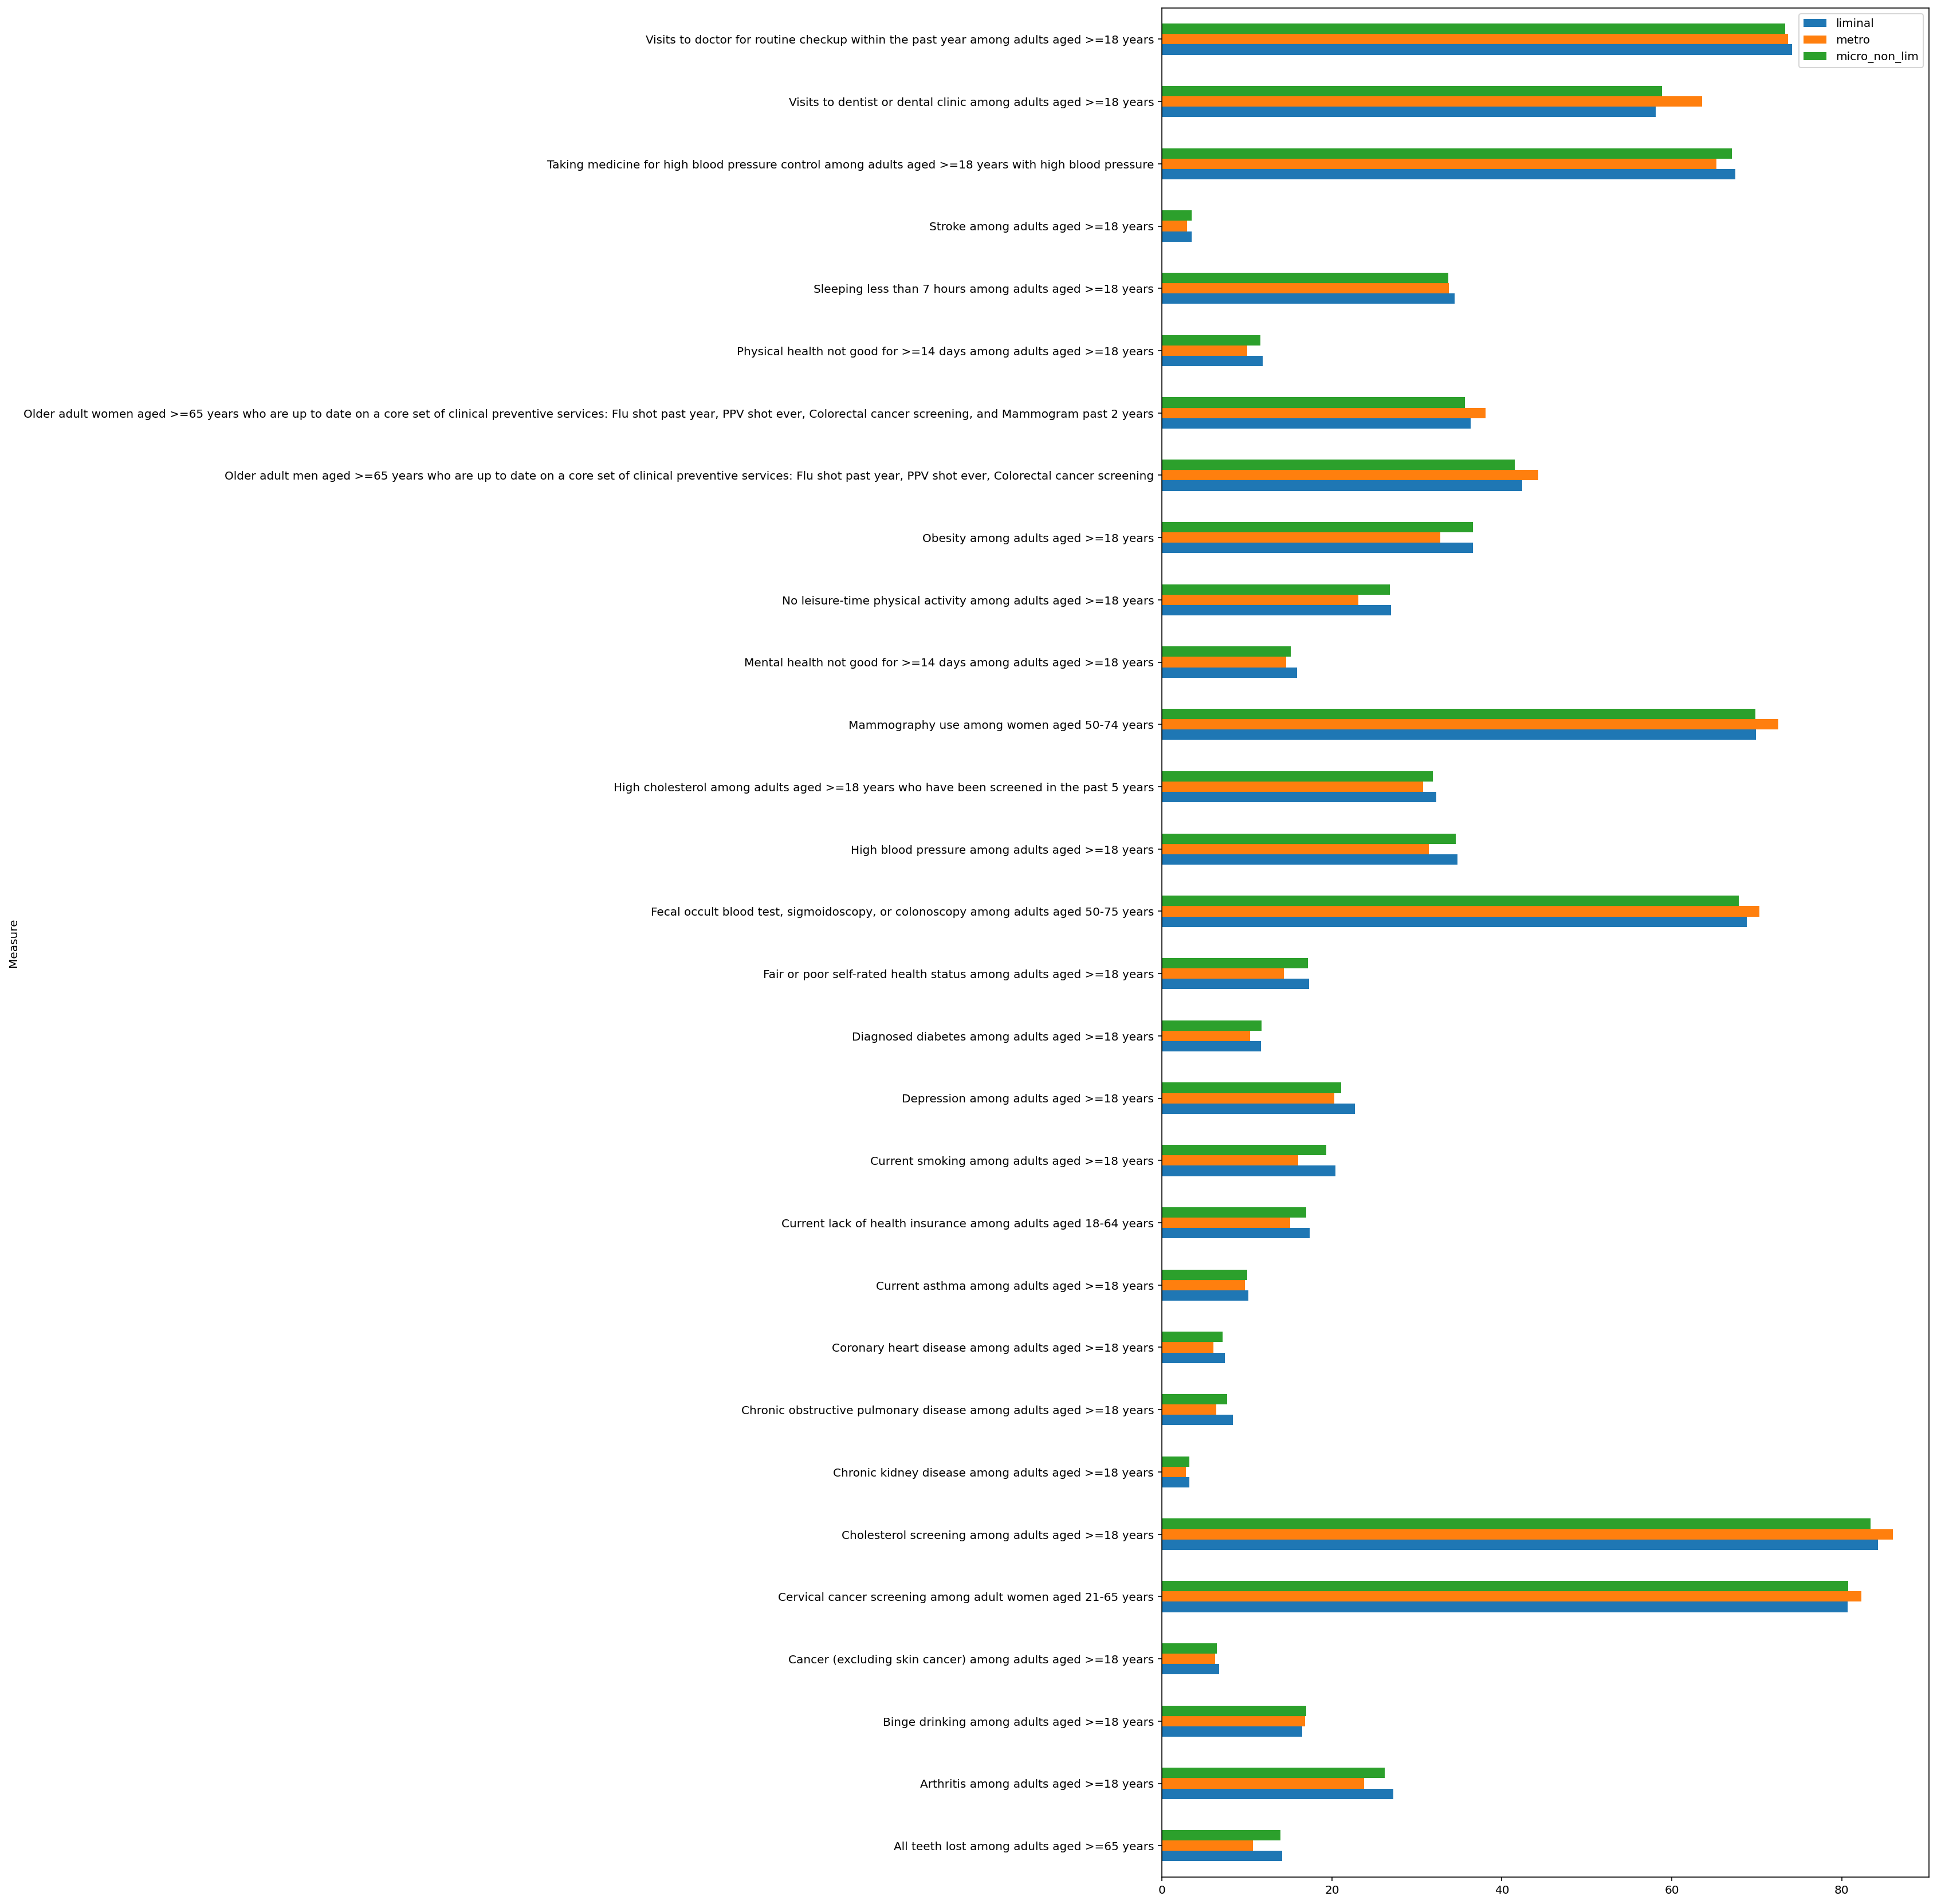

In [61]:
df.plot(kind = 'barh', figsize = (12,30))